# **Importing libraries**

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# **Load Dataset**

In [29]:
file_path = '/content/owid-covid-data.csv'
data = pd.read_csv(file_path)

# **Display first few rows**

In [30]:
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [31]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212746 entries, 0 to 212745
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    212746 non-null  object 
 1   continent                                   201601 non-null  object 
 2   location                                    212746 non-null  object 
 3   date                                        212746 non-null  object 
 4   total_cases                                 198203 non-null  float64
 5   new_cases                                   208224 non-null  float64
 6   new_cases_smoothed                          207564 non-null  float64
 7   total_deaths                                189249 non-null  float64
 8   new_deaths                                  208226 non-null  float64
 9   new_deaths_smoothed                         207566 non-null  float64
 

# **Preprocess the data**

**Convert date to datetime format**

In [33]:
data['date'] = pd.to_datetime(data['date'])

**Identify numeric columns**

In [34]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

**Fill missing values in numeric columns with median values**

In [35]:
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

**Feature selection**

In [36]:
features = ['new_cases', 'new_deaths', 'total_cases', 'total_deaths', 'population']
target = 'new_cases'

**Ensure we have no missing values in selected features**

In [37]:
data = data[features + ['date']].dropna()

# **Split the data into train and test sets**

In [38]:
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Scale the features**

In [39]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Implement Gradient Boosting Regressor**

In [40]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

GradientBoostingRegressor()

# **evaluate the model**

In [48]:
y_pred = gbr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [49]:

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 169.67687975544436
Mean Squared Error (MSE): 27804797.79355093
R-squared (R²): 0.998940375489596


# **Optimize the model using GridSearchCV**

In [42]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5]
}
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [3, 5],
                         'n_estimators': [100, 200]})

**Get the best model**

In [43]:
best_model = grid_search.best_estimator_

# **Predict future cases (next 30 days)**

In [44]:
last_date = data['date'].max()
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 31)]
future_data = pd.DataFrame(future_dates, columns=['date'])

**Assuming we predict based on the last known values**

In [45]:
last_known_values = X.iloc[-1].values.reshape(1, -1)
future_predictions = best_model.predict(np.tile(last_known_values, (30, 1)))

# **Visualization**

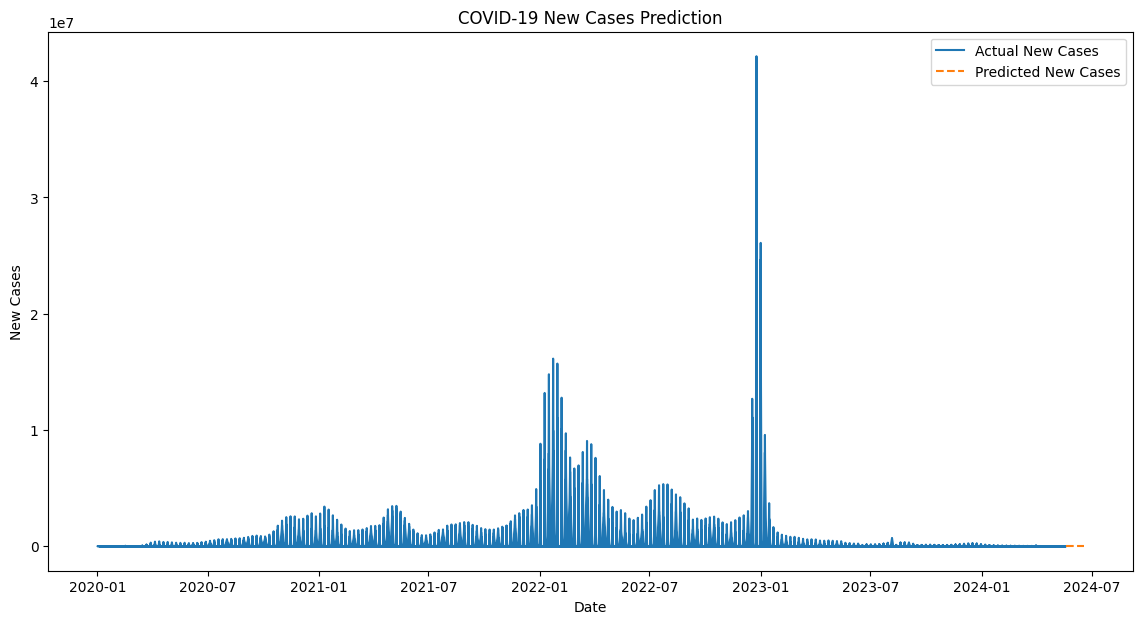

In [46]:
plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['new_cases'], label='Actual New Cases')
plt.plot(future_dates, future_predictions, label='Predicted New Cases', linestyle='--')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.title('COVID-19 New Cases Prediction')
plt.legend()
plt.show()

# **Display best model parameters**


In [50]:
print("Best model parameters:", grid_search.best_params_)

Best model parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
